This code is based on:<br>
https://www.researchgate.net/profile/Wilson_Tolentino_Da_Silva2/publication/333982520_Time_Series_Prediction_A_Naive_Exploration/links/5d10ec94299bf1547c7afe08/Time-Series-Prediction-A-Naive-Exploration.pdf<br>
Adapted and updated by me.<br>
On the published code, Tolentino achieves a Test loss of 0.10234724577159098<br>
This program achieves 0.06509439647197723

Este código está basado en:<br>
https://www.researchgate.net/profile/Wilson_Tolentino_Da_Silva2/publication/333982520_Time_Series_Prediction_A_Naive_Exploration/links/5d10ec94299bf1547c7afe08/Time-Series-Prediction-A-Naive-Exploration.pdf<br>
Adaptado y actualizado por mi.<br>
En el código publicado, Tolentino logra una pérdida de 0.10234724577159098<br>
Este programa logra 0.06509439647197723

#### 1 ANN Univariate Time Series Forecast
#### 1 ANN Predicción de serie de tiempo de una variable
#### baseline_tolentino_original.ipynb
Sliding window/ Ventana deslizante: 1<br>
Input scale/Escala de entrada: [-1, 1]<br>
Optimizer/Optimizador: nadam<br>
Loss/Pérdida: LogCosh<br>
Data/Datos: 2000-01-03 - 2019-03-14<br>
Train Test split/Corte para prueba: 2016-01-01<br>
Hidden neurons/Capa oculta: 12 ReLU<br>
Output layer/Capa de salida: 1 Linear<br>
Epochs: 100<br>
Batch size/Tamaño de lote: 1


In [ ]:
# Not needed on colab
%matplotlib inline
# import main libraries
import numpy as np
import pandas as pd
import tensorflow as tf

##### 1.1 Ensuring reproducibility of results by seeding both numpy and tensorflow random generators.
##### 1.1 Asegura la reproducibilidad de los resultados fijando la semilla de los generadores aleatorios de numpy  y tensorflow.

In [ ]:
from numpy.random import seed
seed(314159)
from tensorflow.random import set_seed
set_seed(271828)

##### 1.2 Download CSV data from source
##### 1.2 Bajar el CSV de la fuente
I downloaded the data from Yahoo finance and prepared the file baseline_tolentino.csv with the same data as the original thesis.

Yo bajé los datos a mano y prepare el archivo baseline_tolentino.csv con los mismos datos usados en la tesis original.

In [ ]:
path_to_downloaded_file = tf.keras.utils.get_file(
    "baseline_tolentino.csv",
    "https://raw.githubusercontent.com/jmacostap/webstore/master/"+
    "baseline_tolentino.csv",
    cache_dir="/content",
    )

335872/328946 [==============================] - 0s 0us/step


##### 1.3 Data Analysis
##### 1.3 Análisis de datos
The following cells handle importing the data into an adequate format, and doing initial exploration, by visualising available data and plotting its graph, as well as dropping features that will not be considered for the purpose of this experiment.

Las siguientes celdas manejan el formato y la exploración inicial de los datos mediante la visualización gráfica y purgan los datos innecesarios para este experimento.

In [ ]:
df = pd.read_csv(path_to_downloaded_file)
print(len(df), " lines read")
df = df.iloc[::-1] #reverse order
df.head()

4829  lines read


,Date,Open,High,Low,Close,Volume
4828,2019-03-14,2810.379883,2815.000000,2803.459961,2808.479980,3469730000
4827,2019-03-13,2799.780029,2821.239990,2799.780029,2810.919922,3766150000
4826,2019-03-12,2787.340088,2798.320068,2786.729980,2791.520020,3414230000
4825,2019-03-11,2747.610107,2784.000000,2747.610107,2783.300049,3749030000
4824,2019-03-08,2730.790039,2744.129883,2722.270020,2743.070068,3423130000


In [ ]:
df = df.iloc[::-1] #reverse order
df.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(['Date'], drop=True)
df.head(10)

,Close
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971
2000-01-10,1457.599976
2000-01-11,1438.560059
2000-01-12,1432.250000
2000-01-13,1449.680054


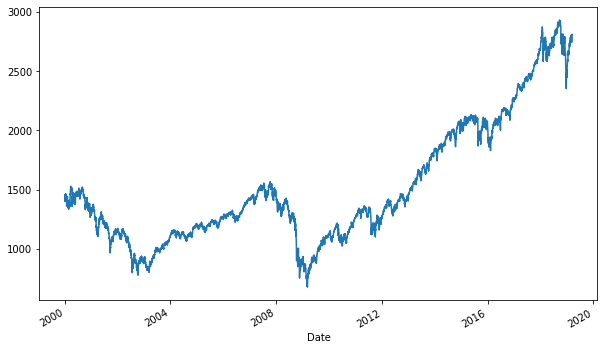

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,6 ))
df['Close'].plot()

##### 1.4 Data Pre-processing
##### 1.4 Pre-procesamiento de datos
The following cells split the resulting dataset into training and testing data, and scales the results for optimal predictions.

Estas celdas separan los datos en entrenamiento y prueba, y escalan los resultados para optimizar las predicciones.

In [ ]:
test_split = pd.Timestamp('2016-01-01')
print('Test split: {}'.format(test_split))
df = df['Close']

Test split: 2016-01-01 00:00:00


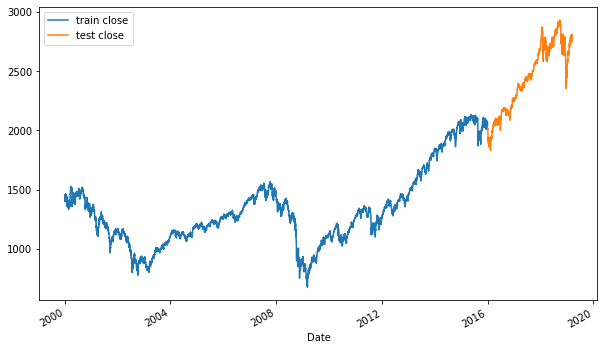

In [ ]:
train_close = df.loc[:test_split]
test_close = df.loc[test_split:]
plt.figure(figsize=(10,6))
axis = train_close.plot()
test_close.plot(ax=axis)
plt.legend(['train close','test close'])
train_close = train_close.values.reshape(-1,1)
test_close = test_close.values.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_close_scaled = scaler.fit_transform(train_close)
test_close_scaled = scaler.transform(test_close)

In [ ]:
X_train = train_close_scaled[:-1]
y_train = train_close_scaled[1:]
X_test = test_close_scaled[:-1]
y_test = test_close_scaled[1:]

##### 1.5 Model definition and training
##### 1.5 Definición del modelo y entrenamiento
The following cells define the ANN model, as a sequence of an input layer, a 12 hidden neurons layer,
and an output layer. The activation function will be ReLU, with LogCosh loss and nadam optimizer. This model will run over 100 epochs.

Aquí se define el modelo de la RNA como una secuencia de una capa de entrada, una capa oculta de 12 neuronas ReLU, y una capa de salida lineal, entrenadas con una función de pérdida LogCosh y un optimizador nadam sobre 100 epochs.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
ann = Sequential()
ann.add(Dense(units=12, input_dim=1, activation='relu'))
ann.add(Dense(units=1)) 
ann.compile(loss='logcosh', optimizer='nadam')

In [ ]:
ann_history = ann.fit(x=X_train,
                      y=y_train,
                      epochs=100,
                      batch_size=1,
                      verbose=2,
                      shuffle=False)

Epoch 1/100
4024/4024 - 3s - loss: 3.0301e-04
Epoch 2/100
4024/4024 - 2s - loss: 3.2375e-04
Epoch 3/100
4024/4024 - 2s - loss: 3.1136e-04
Epoch 4/100
4024/4024 - 2s - loss: 3.0790e-04
Epoch 5/100
4024/4024 - 3s - loss: 3.0597e-04
Epoch 6/100
4024/4024 - 3s - loss: 3.0106e-04
Epoch 7/100
4024/4024 - 3s - loss: 2.9679e-04
Epoch 8/100
4024/4024 - 3s - loss: 2.9310e-04
Epoch 9/100
4024/4024 - 3s - loss: 2.8902e-04
Epoch 10/100
4024/4024 - 2s - loss: 2.8646e-04
Epoch 11/100
4024/4024 - 3s - loss: 2.8545e-04
Epoch 12/100
4024/4024 - 2s - loss: 2.8361e-04
Epoch 13/100
4024/4024 - 2s - loss: 2.8339e-04
Epoch 14/100
4024/4024 - 2s - loss: 2.8237e-04
Epoch 15/100
4024/4024 - 3s - loss: 2.8351e-04
Epoch 16/100
4024/4024 - 2s - loss: 2.8267e-04
Epoch 17/100
4024/4024 - 2s - loss: 2.8168e-04
Epoch 18/100
4024/4024 - 2s - loss: 2.8132e-04
Epoch 19/100
4024/4024 - 2s - loss: 2.8095e-04
Epoch 20/100
4024/4024 - 2s - loss: 2.7937e-04
Epoch 21/100
4024/4024 - 2s - loss: 2.7880e-04
Epoch 22/100
4024/4024

##### 1.6 Prediction and Accuracy
##### 1.6 Predicción y Exactitud
The following cells use the trained model with the test data. This result is outputted in the form of an R2 score, for both the train dataset and the test dataset. The loss is also calculated. The last cell will plot the resulting predictions, alongside the ground truth. At this point, data has not been
scaled back to its original state.

A continuación se prueba el modelo entrenado con los datos de prueba y se calcula el índice R2 y la pérdida. Luego se grafica la predicción contra el valor real. Los datos no han sido devueltos a su escala original.

In [ ]:
from sklearn.metrics import r2_score
y_train_pred_ann = ann.predict(X_train)
y_pred_test_ann = ann.predict(X_test)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_ann)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_ann)))

The R2 score on the Train set is:	0.746
The R2 score on the Test set is:	0.118


In [ ]:
ann_test = ann.evaluate(x=X_test,
                        y=y_test,
                        batch_size=1)
print("ANN: {}".format(ann_test))


803/803 [==============================] - 1s 732us/step - loss: 0.0651
ANN: 0.06509439647197723


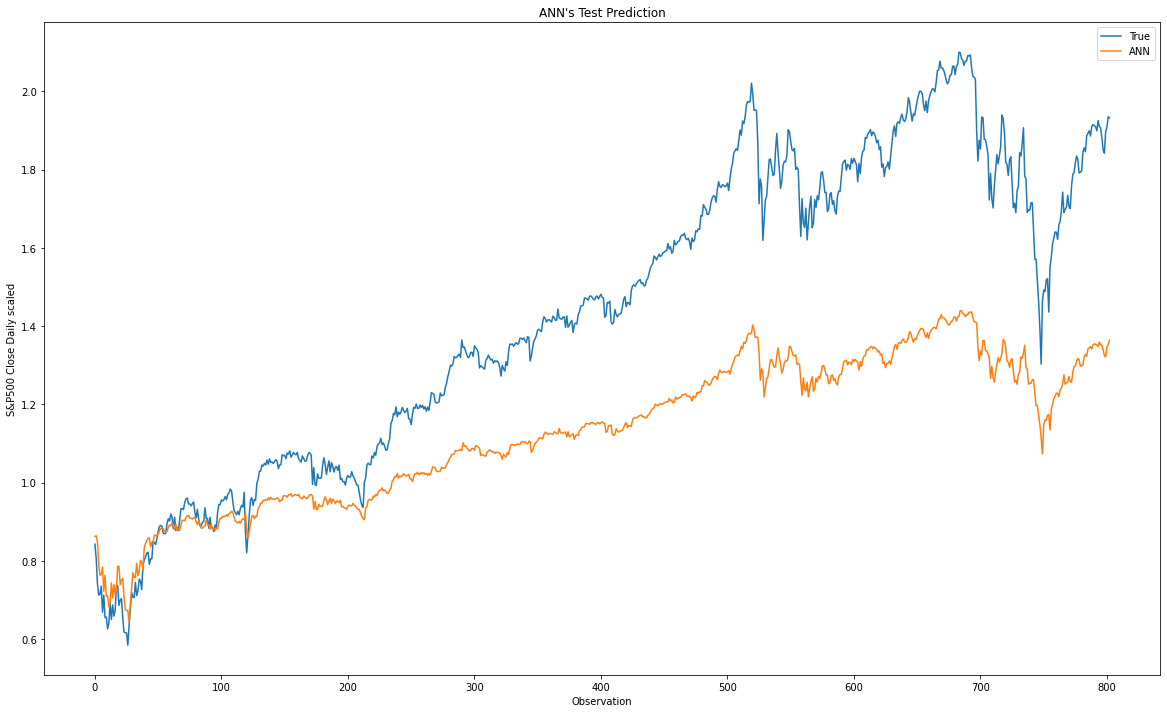

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 12))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_ann, label='ANN')
plt.title("ANN's Test Prediction")
plt.xlabel('Observation')
plt.ylabel('S&P500 Close Daily scaled')
plt.legend()
plt.show()


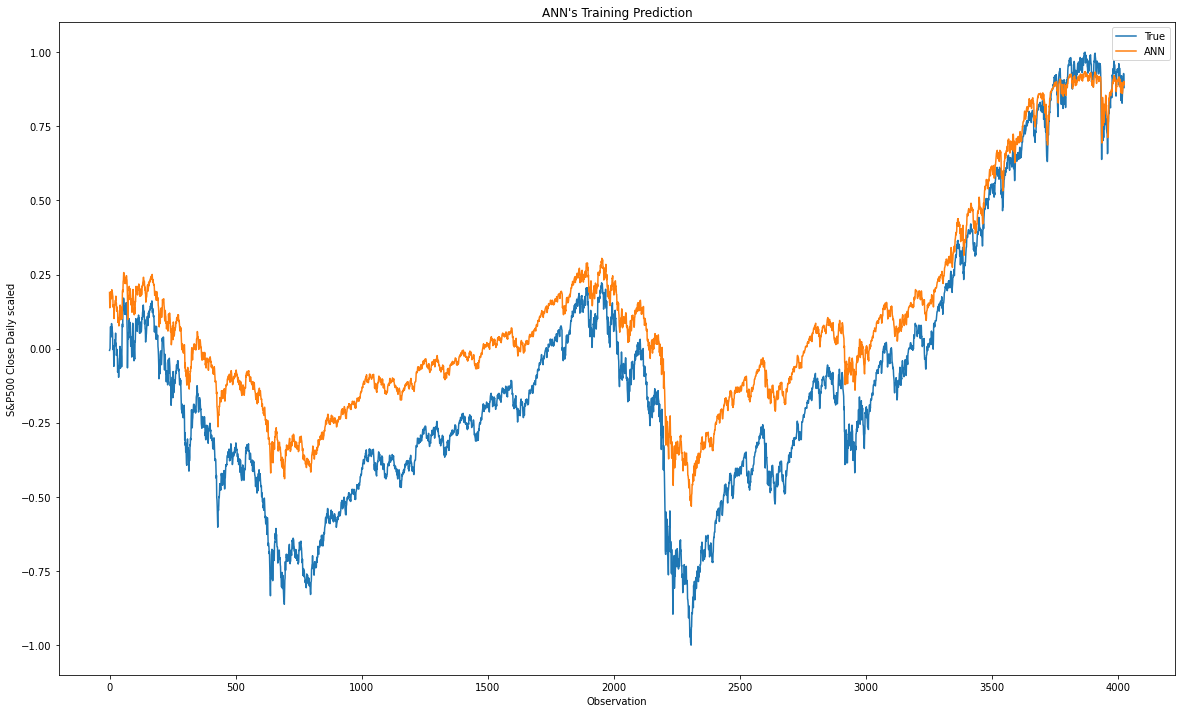

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 12))
plt.plot(y_train, label='True')
plt.plot(y_train_pred_ann, label='ANN')
plt.title("ANN's Training Prediction")
plt.xlabel('Observation')
plt.ylabel('S&P500 Close Daily scaled')
plt.legend()
plt.show()
